In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import copy

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from matplotlib import rcParams

from astropy.io import fits

# This is my shitty code...work in progress, but at least does not depend on Pyraf now
import kungpao
from kungpao.io import save_to_fits
from kungpao.display import display_single
from kungpao.isophote import galSBP, bmodel, plotting

# This is just how I like my figure
plt.rc('text', usetex=True)
rcParams.update({'axes.linewidth': 1.5})
rcParams.update({'xtick.direction': 'in'})
rcParams.update({'ytick.direction': 'in'})
rcParams.update({'xtick.minor.visible': 'True'})
rcParams.update({'ytick.minor.visible': 'True'})
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '8.0'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '4.0'})
rcParams.update({'xtick.minor.width': '1.5'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '8.0'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '4.0'})
rcParams.update({'ytick.minor.width': '1.5'})
rcParams.update({'axes.titlepad': '10.0'})
rcParams.update({'font.size': 25})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Checking the data

* The galaxy is at z=0.01017, (189.98, -0.138719)

In [4]:
data_dir = '/Users/song/Dropbox/work/temp/dwarf_demo'
dwarf_fits = fits.open(os.path.join(data_dir, 'forsong_example_SID63527.fits'))

# Images in g, r, and i band
g_img = dwarf_fits[0].data
r_img = dwarf_fits[1].data
i_img = dwarf_fits[2].data

# Makss 
mask = dwarf_fits[3].data

print(g_img.shape)

(1201, 1201)


#### Check the images and masks

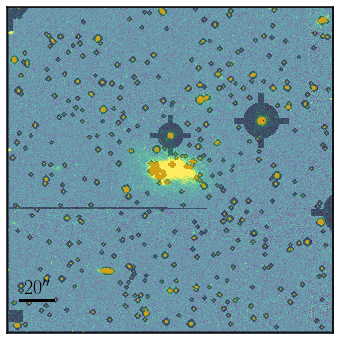

In [5]:
fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(111)

_ = display_single(i_img, ax=ax1, scale_bar_length=20.0, scale_bar_y_offset=1.2, 
                   scale_bar_color='k')

# Overplot the mask
_ = ax1.imshow(mask.astype('uint8'), origin='lower', cmap='Reds', alpha=0.3)

### Prepare files and configs for `ellipse`

In [5]:
# Unfortunately...x_isophote.e only deals with FITS format, so we need to save the 
# images and mask to individual fits file
g_fits = os.path.join(data_dir, 'dwarf_example_g.fits')
r_fits = os.path.join(data_dir, 'dwarf_example_r.fits')
i_fits = os.path.join(data_dir, 'dwarf_example_i.fits')
mask_fits = os.path.join(data_dir, 'dwarf_example_mask.fits')

_ = save_to_fits(g_img, g_fits, overwrite=True)
_ = save_to_fits(r_img, r_fits, overwrite=True)
_ = save_to_fits(i_img, i_fits, overwrite=True)
_ = save_to_fits(mask.astype('uint8'), mask_fits, overwrite=True)

* Right now, user has to pass all the parameters to a "core function" called `galSBP` (galaxy surface brightness profile). This includes both geometric parameters of the galaxy and the parameters that control the behavior of `ellipse`. Below is a list of key parameters.
* In the future, this will be replaced by a more intuitive configuration structure.
* The main workflow is determined by the `step` parameter.  The most thorough workflow assumes no prior knowledge of the galaxy shape:
    - `stage=1`: every parameter is free includes the centroid. Can help define a intensity weighted galaxy central position. If you already know the centroid, you can skip this step.
    - `stage=2`: fix the center, but allows different shape for isophotes. Useful for estimating an average isophotal shape (to define the orientation of the major axis and the axis ratio) and extracting 1-D ellipticity and position angle profiles. If you do not care about shape information and already know the shape of the galaxy (e.g. from CModel or SExtractor), you can skip this step.
    - `stage=3`: fix both the isophotal center and shape, only extract 1-D intensity profile alone the major axis. We will convert this one later into the surface brightness profiles used for most analysis (e.g. derive R50; fit Sersic profile).
    - `stage=4`: if you want to derive color gradient along the major axis, a reliable way is to run `stage 1-3` on a *reference* image (e.g. image with the best seeing, most accurate background, less affected by dust, etc). The use the `step 3` output as "template" to run "force-photometry" on the other bands.
    - `stage 1` and `stage 2` can be time consuming on large images (size > 1000 pixels). `step 3` is usually fast. `stage 4` involves no fitting, so it basically takes no time. Unless you care about the shape difference between different bands, usually it is not necessary to run the whole process on images in different filters.
* I will show the full process below as example.

In [36]:
# Galaxy center: 
#    could be values measured somewhere else, or just use image center as
#    initial guess
x0_ini, y0_ini = i_img.shape[0] / 2.0, i_img.shape[1] / 2.0

# Axis ratio and Position angle:
#     You could measure them elsewhere and fix them; 
#     Or you can determine them using isophote analysis
#     Initial guesses are b/a=0.9, pa=0.0

ba_ini, pa_ini = 0.9, 0.0

# sma_ini: Initial semi-major axis length to start the measure
#     Normally we pixel a small radii to start, but should contain more than a few pixels.
# sma_min, sma_max: Minimum and maximum radius for isophote analysis
#     Usually sma_min == 0, unless there is saturation or the center is masked out
#     Maximum radius can be the size of the image. `Ellipse` will stop automatically when
#     there is no signal

sma_ini, sma_min, sma_max = 16.0, 0.0, 500.0

# step: step size for relative flux change along the major axis
#     This is in log scale; smaller step means finer radial binning, but poorer S/N per
#     isophote and could lead to failed run.
#     Small step size is not great idea if you want to determine the b/a or PA profile.
step = 0.2

# stage: behaviour of Ellipse fitting
#     Ellipse can fix certain parameters at the input values or fit everything
#     1  Fit everything, let the center, shape of each isophote to be free
#     2  Fix the central coordinate of every isophote at the x_cen / y_cen position
#     3  Fix the central coordinate and shape of every isophote at input values
#     4  This is the "force photometry" mode, need an external Ellipse output binary 
#        table as template (use `inEllip` parameter)
# Here we start with stage 1
stage = 1

# integrade_mode: how to estimate the intensity along the isophote
#     options are: mean, median, bi-linear
#     For noisy data with masked regions, median seems to work well
integrade_mode = 'median'

# Along each isophote, `ellipse` can perform sigma clipping to remove outliers 
# Even with masks, this can help reduce the impact of contaminations and small structures
# n_clip: number of sigma-clipping to run
# low_clip: lower threshold. 2 means 2-sigma 
# upp_clip: upper threshold
n_clip, low_clip, upp_clip = 2, 3.0, 3.0

# Pixel scale, zeropoint, exposure time: convert measured intensity into surface brightness
# Just fill the HSC coadd values
pix_scale, zeropoint, exptime = 0.168, 27.0, 1.0

# `galSBP` will try the fitting processes a few times if `ellipse` encounters some issues: e.g. 
# initial radius is not good, step size is too small, or fitting radius range is too large. 
# Each time, it will try to make it "easier"
n_try_max = 2

#### Stage 1

* In `stage 1`, we allow center and geometry to be free

* We use i-band image as "reference"

* I know, I know....I clearly should have used a configuration structure...

In [10]:
# If you know the center is not far from the image center, you can use a small `sma_ini` to save time.
sma_ini_cen = 6

ell_i_1, bin_i_1 = galSBP.galSBP(
    i_fits, mask=mask_fits, galX=x0_ini, galY=y0_ini, galQ=ba_ini, galPA=pa_ini,
    iniSma=sma_ini_cen, minSma=sma_min, maxSma=sma_max,
    pix=pix_scale, zpPhoto=zeropoint, expTime=exptime, 
    stage=stage, ellipStep=step,
    uppClip=upp_clip, lowClip=low_clip, nClip=n_clip, 
    maxTry=n_try_max, intMode=integrade_mode)

...Running ellipse in step 1 
> Attempts: 1


It is a good idea to overlap some isophotes on the image to check weather `ellipse` run is Ok

The image is pretty large, so we will zoom in a little

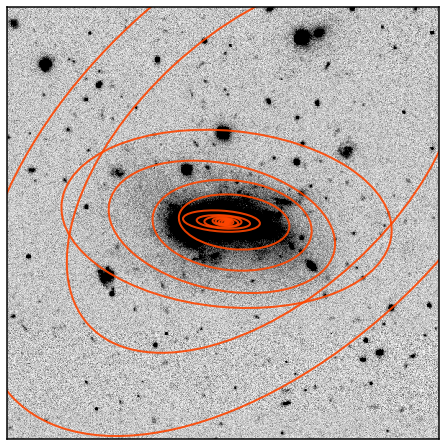

In [11]:
plotting.display_isophote(i_img, ell_i_1, zoom=2, cmap='Greys')

* The fitting looks Ok. Now we can take a look at the 1-D profile of central position and the amplitudes of the Fourier terms (how far the isophote deviates from perfect elliptical shape)


* **NOTICE**: the X-axis is in $R^{1/4}$ coordinate...it is a little weird. But linear scale squeezes the central region while the $\log$ scale emphases the inner region too much. $R^{1/4}$ is a balance.  Also if the galaxy follows the De Vaucouleurs profile ($n_{\rm Ser}=4$, it will appear as a straight line under this coordinate.

* The galaxy seems to have a well defined center. The `X0` and `Y0` do not jump around a lot in the inner region. You can choose the real "central" position or use the average value within a radial range; you can also flux-weight the average.

* At very large radii, the centroid drifts away from the galaxy. This is probably due to some unmasked flux from nearby sources. This is actually a useful way to see if the mask is good enough for the low surface brightness outskirt. 

* If you care about small variation of the isophotal center, you can limit the `maxSma` to the galaxy size. 

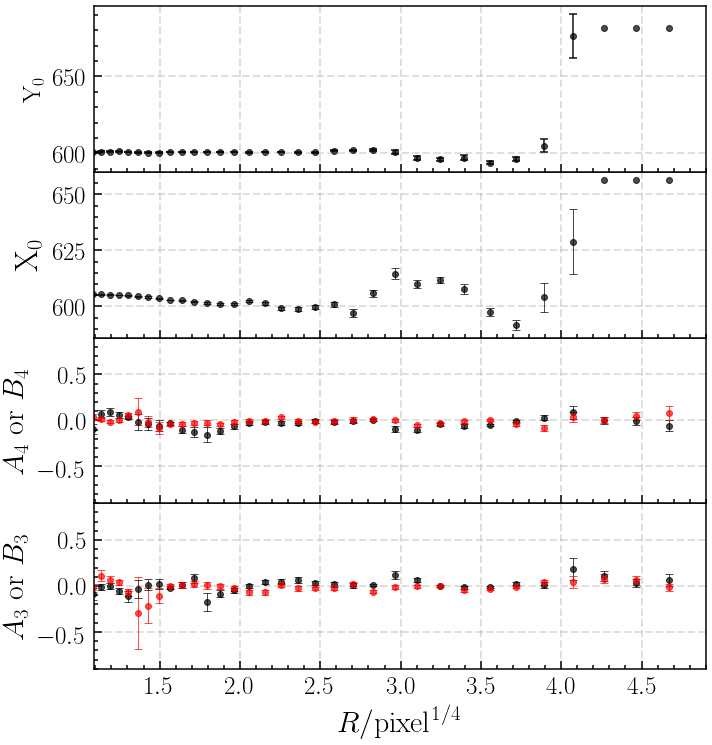

In [12]:
_ = plotting.display_center_fourier(ell_i_1, x_max=4.9)

* The `ell_i_1` output is just an `astropy.table`, you should be able to view it in the notebook.

* Besides the default outputs from `ellipse` (about ~45 columns), there are also some "value-added" information from my code, including an average `X0` and `Y0`.
    - This is just based on a receipe that works for most of my massive galaxy sample, may not be the best for your galaxy. You should feel free to estimate it by yourself.
    - Will provide a more flexible way to do this, including using a 2-D aperture photometry result as default using `sep`.
    - The output format is also not perfect. I plan to make it easier to understand.

In [13]:
ell_i_1

sma,intens,int_err,pix_var,rms,ell,ell_err,pa,pa_err,x0,x0_err,y0,y0_err,grad,grad_err,grad_r_err,rsma,mag,mag_lerr,mag_uerr,tflux_e,tflux_c,tmag_e,tmag_c,npix_e,npix_c,a3,a3_err,b3,b3_err,a4,a4_err,b4,b4_err,ndata,nflag,niter,stop,a_big,sarea,A1,A1_err,B1,B1_err,A2,A2_err,B2,B2_err,A3,A3_err,B3,B3_err,A4,A4_err,B4,B4_err,pa_norm,sbp_ori,sbp_sub,sbp,intens_sub,intens_bkg,sbp_err,sbp_low,sbp_upp,sma_asec,rsma_asec,growth_ori,growth_sub,avg_x0,avg_y0,avg_q,avg_pa,avg_bkg,intens_cor,sbp_cor,growth_cor,rad_outer,mag_tot,mag_tot_ori,mag_tot_sub
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.0,3.082152,nan,nan,nan,nan,nan,nan,nan,605.3668,nan,601.1194,nan,0.03763369,nan,nan,0.0,52.777860000000004,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,21.904411276977765,21.904411276977765,21.904411276977765,3.082152,0.0,nan,nan,nan,0.0,0.0,0.0,0.0,603.0092816879392,600.9115834966186,0.39793522340993936,-84.11008753269456,0.0,3.082152,21.904411276977765,0.0,400.8000380511647,16.68081271726524,16.68081271726524,16.68081271726524
0.560783,3.103256,0.002017902,0.01028932,0.007275649,0.8952392,nan,-179.2532,nan,605.3668,nan,601.1194,nan,-0.01348984,nan,nan,0.8653638,52.77046,0.0007057726,0.0007062851,3.082152,3.082152,52.777860000000004,52.777860000000004,1.0,1.0,0.1536475,0.4382009,-0.04624936,0.4039403,0.0355555,0.3664485,0.6409086,0.6175669,13,0,1.0,4.0,0.00848517,2.0,0.002361,0.00227097,-0.004000089,0.002194271,0.0002742082,0.001419573,0.005409061,0.001367101,0.0001146278,0.001415439,-0.0004802295,0.001353634,3.760431e-05,0.001426657,-6.098644e-05,0.001344244,-0.7468000000000075,21.897002399252024,21.897002399252024,21.897002399252024,3.103256,0.0,0.0007057739499636284,21.89629662530206,21.897708173201988,0.09421154400000001,0.5540207493231265,0.0,0.0,603.0092816879392,600.9115834966186,0.39793522340993936,-84.11008753269456,0.0,3.103256,21.897002399252024,0.0,400.8000380511647,16.68081271726524,16.68081271726524,16.68081271726524
0.6729397,3.104144,0.002455581,0.01252105,0.008853722,0.8952392,nan,-179.2532,nan,605.3668,nan,601.1194,nan,-0.0168623,nan,nan,0.9057202,52.77015,0.0008590075,0.0008586938,3.082152,3.082152,52.777860000000004,52.777860000000004,1.0,1.0,0.1108325,0.3525092,0.00540854,0.3263072,0.01710994,0.2917615,0.5441234,0.5146772,13,0,1.0,4.0,0.00848517,2.0,0.002786011,0.002804602,-0.00431606,0.00270988,0.0003015258,0.00166466,0.006888205,0.001603128,0.0001504099,0.001655339,-0.000669242,0.001583059,5.666424e-05,0.001668012,-0.0001302305,0.001571657,-0.7468000000000075,21.89669175912688,21.89669175912688,21.89669175912688,3.104144,0.0,0.0008585488354384552,21.895833210291443,21.89755030796232,0.11305386960000001,0.5798576057358905,0.14136220698988292,0.14136220698988292,603.0092816879392,600.9115834966186,0.39793522340993936,-84.11008753269456,0.0,3.104144,21.89669175912688,0.14136220698988292,400.8000380511647,16.68081271726524,16.68081271726524,16.68081271726524
0.8075276,3.105218,0.002974371,0.01516637,0.01072425,0.8952392,nan,-179.2532,nan,605.3668,nan,601.1194,nan,-0.02107788,nan,nan,0.9479585,52.76977,0.001040483,0.001039419,3.082152,3.082152,52.777860000000004,52.777860000000004,1.0,1.0,0.08171439,0.2830929,0.0311372,0.2645898,0.007061769,0.2324507,0.4527943,0.4232697,13,0,1.0,4.0,0.00848517,2.0,0.003313218,0.003432446,-0.004672507,

#### Stage 2

* Now in `stage 2`, we update and **fix** the center, but still fit the shape of each isophote 

* This should be much faster!

In [32]:
stage = 2

x_cen, y_cen = ell_i_1[0]['avg_x0'], ell_i_1[0]['avg_y0']

ell_i_2, bin_i_2 = galSBP.galSBP(
    i_fits, mask=mask_fits, galX=x_cen, galY=y_cen, galQ=ba_ini, galPA=pa_ini,
    iniSma=iniSma, minSma=sma_min, maxSma=sma_max,
    pix=pix_scale, zpPhoto=zeropoint, expTime=exptime, 
    stage=stage, ellipStep=step,
    uppClip=upp_clip, lowClip=low_clip, nClip=n_clip, 
    maxTry=n_try_max, intMode=integrade_mode)

...Running ellipse in step 2 
> Attempts: 1


* Now let's check the isophotes again and see if we are happy about the average isophotal shape

* The result looks reasonable to me. In the outer region, the S/N becomes quite low, and it becomes very difficult for `ellipse` to reliably fit isophotal shape. So be careful about how to interpret those values. If you change the `smaIni` or `smaMax` values a little but the result varies a lot, it means those shape values are not reliable. 
    - `step` (step size) is another parameter. Normally you don't want to use very small step size when fitting isophotal shape. It means there will be smaller amount of pixels in each annuli. `step=0.2` usually is a good choice.

* It is a good sign that the outer ellipticity becomes very small. That does **NOT** necessarily mean the galaxy becomes rounder in the outskirt, but at least it means there is no strong source of contamination that could bias the measurement.
    - You should **NOT** trust the whole 1-D ellipticity or position angle profile. The outer boundary should be determined by the S/N (or background systematic issue) of the final surface brightness profile.

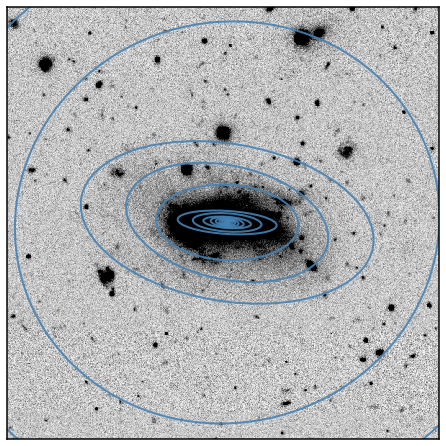

In [33]:
plotting.display_isophote(i_img, ell_i_2, zoom=2, cmap='Greys', iso_color='steelblue')

In [34]:
ell_i_2

sma,intens,int_err,pix_var,rms,ell,ell_err,pa,pa_err,x0,x0_err,y0,y0_err,grad,grad_err,grad_r_err,rsma,mag,mag_lerr,mag_uerr,tflux_e,tflux_c,tmag_e,tmag_c,npix_e,npix_c,a3,a3_err,b3,b3_err,a4,a4_err,b4,b4_err,ndata,nflag,niter,stop,a_big,sarea,A1,A1_err,B1,B1_err,A2,A2_err,B2,B2_err,A3,A3_err,B3,B3_err,A4,A4_err,B4,B4_err,pa_norm,sbp_ori,sbp_sub,sbp,intens_sub,intens_bkg,sbp_err,sbp_low,sbp_upp,sma_asec,rsma_asec,growth_ori,growth_sub,avg_x0,avg_y0,avg_q,avg_pa,avg_bkg,intens_cor,sbp_cor,growth_cor,rad_outer,mag_tot,mag_tot_ori,mag_tot_sub
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.0,3.152464,nan,nan,nan,nan,nan,nan,nan,605.0,nan,600.0,nan,-0.07674225,nan,nan,0.0,52.753370000000004,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,21.87992106916094,21.87992106916094,21.87992106916094,3.152464,0.0,nan,nan,nan,0.0,0.0,0.0,0.0,605.0000000000001,600.0000000000002,0.38437810525292604,-88.21203321466068,0.0,3.152464,21.87992106916094,0.0,390.88334818624656,16.696827239316995,16.696827239316995,16.696827239316995
0.5008135,3.114031,0.00517629,0.02639401,0.01866338,0.5940436,0.04918465,-84.16868,3.495877,605.0,0.03025734,600.0,0.01304297,-0.07268048,0.1534028,2.110647,0.8412383,52.76669,0.001805965,0.001803574,3.152464,3.152464,52.753370000000004,52.753370000000004,1.0,1.0,0.1061535,0.2269811,0.08293393,0.1784617,-0.03911147,0.08378093,0.09254333,0.1957908,13,0,200.0,2.0,8.797878e-07,2.0,3.481013e-05,0.0004931822,-0.0004383686,0.0004765256,6.945067e-05,0.000473747,-0.000420976,0.0004562357,2.06073e-05,0.0004689044,-0.0002376396,0.0004484296,-1.659638e-05,0.0004718371,8.254116e-05,0.0004445807,-84.16868,21.893239079553616,21.893239079553616,21.893239079553616,3.114031,0.0,0.0018032638862059969,21.89143581566741,21.895042343439822,0.08413666800000001,0.5385751700552364,0.0,0.0,605.0000000000001,600.0000000000002,0.38437810525292604,-88.21203321466068,0.0,3.114031,21.893239079553616,0.0,390.88334818624656,16.696827239316995,16.696827239316995,16.696827239316995
0.6009762,3.10757,0.006094606,0.03107651,0.02197441,0.6031461,0.04934882,-83.05843,3.477123,605.0,0.03719702,600.0,0.01588216,-0.06963605,0.1504785,2.160927,0.8804695,52.768950000000004,0.002131436,0.00212735,3.152464,3.152464,52.753370000000004,52.753370000000004,1.0,1.0,0.103236,0.225881,0.09810159,0.2146806,-0.04431877,0.09708791,0.08449269,0.1831996,13,0,200.0,2.0,1.261706e-07,2.0,3.944178e-05,0.0006351386,-0.0005279936,0.0006136876,7.837157e-05,0.0006135082,-0.0005071548,0.0005908308,1.372018e-05,0.0006103124,-0.0002471295,0.0005836631,-1.951538e-05,0.0006143504,9.609284e-05,0.0005788615,-83.05843,21.89549410816785,21.89549410816785,21.89549410816785,3.10757,0.0,0.002127274383251887,21.893366833784597,21.8976213825511,0.1009640016,0.5636916981838892,0.4052803287325122,0.4052803287325122,605.0000000000001,600.0000000000002,0.38437810525292604,-88.21203321466068,0.0,3.10757,21.89549410816785,0.4052803287325122,390.88334818624656,16.696827239316995,16.696827239316995,16.696827239316995
0.7211715,3.100745,0.00709868,0.03619631,0.02559466,0.6181924,0.04975497,-81.90505,3.457657,605.0,0.04666843,600.0,0.0195297,-0.06542224,0.1459432,2.230789,0.9215304,52.771339999999995,0.002487839,0.002483419,3.152464,3.152464,52.753370000000004,52.753370000000004,1.0,1.0,0.09880698,0.2233173,0.114841,0.25

* Now we can check the 1-D profiles for ellipticity and position angle. 
    - The following quick-look QA figure also includes the surface intensity profile.
    
* The position angle varies significatly inside $1.5^4=5.1$ pixels. This area is affected by seeing. In star-forming galaxy, it could also affected by dust, so unless there is very good reason to do so, I normally ignore the central region when estimating a good average ellipticity and PA. Both `e` and `PA` do not vary much outside the inner region, which means there is no problem to derive the surface brightness profile along the major axis.
    - For galaxy with strong isophotal-twist (PA varies significantly) or galaxy with important substructures (e.g. spiral with strong bar), it is hard to say what's the right choice. I think it depends on the scientific applications. And if isophotal twist is common, it is a good idea to explore the impact of PA choice on the final proposal; or one can just use the profile from `stage=2` with a varying major axis.
    - Both `e` and `PA` becomes flat outside a raidus. This normally means that the S/N is too low to fit isophotal shape. You can use the final surface brightness profile to determine a useful range for these parameters. Or you can use the `niter` and `stop` columns in the output catalog. If `niter == 1` or `stop == 4`, it means the shape fitting is failed. (Currently, I mistakenly convert `stop` flag to float number...will be fixed.).

* Orange-ish dashed lines show the average `e` and `PA` picked by my old recipe, which are not perfect in this case, but not too bad.
    - Will have a more flexible recipe to decide average values.

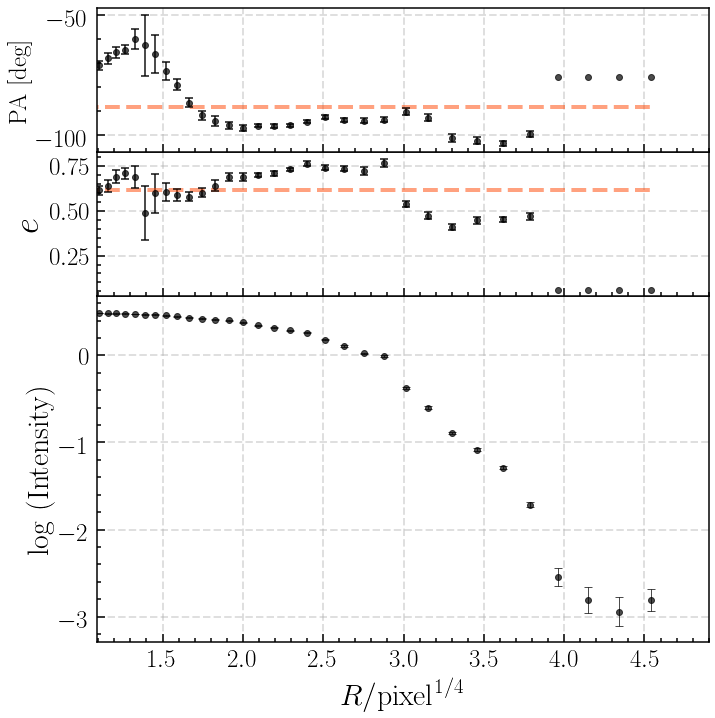

In [35]:
_ = plotting.display_intensity_shape(ell_i_2, x_max=4.9)

In [37]:
print("Average ellipticity is {:4.2f}".format(1.0 - ell_i_2['avg_q'][0]))
print("Average PA is {:5.1f}".format(ell_i_2['avg_pa'][0]))

Average ellipticity is 0.62
Average PA is -88.2


#### Stage 3

* Now in `stage 3`, we update and **fix** the center **and** the shape of each isophote.

* This should be even faster!

In [38]:
stage = 3

ba_cen, gal_cen = ell_i_2[0]['avg_q'], ell_i_2[0]['avg_pa']

ell_i_3, bin_i_3 = galSBP.galSBP(
    i_fits, mask=mask_fits, galX=x_cen, galY=y_cen, galQ=ba_cen, galPA=gal_cen,
    iniSma=sma_ini, minSma=sma_min, maxSma=sma_max,
    pix=pix_scale, zpPhoto=zeropoint, expTime=exptime, 
    stage=stage, ellipStep=step,
    uppClip=upp_clip, lowClip=low_clip, nClip=n_clip, 
    maxTry=n_try_max, intMode=integrade_mode)

...Running ellipse in step 3 
> Attempts: 1


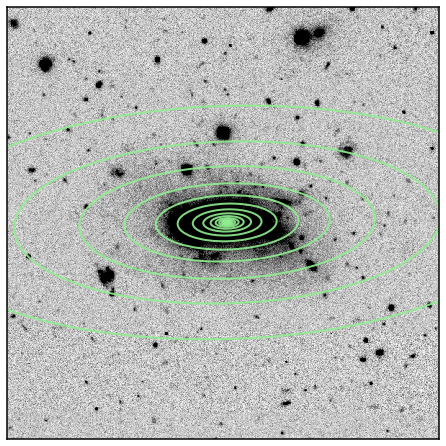

In [39]:
plotting.display_isophote(i_img, ell_i_3, zoom=2, cmap='Greys', iso_color='lightgreen')

* And now we have the intensity profile along the major axis, it looks like an exponential to me.

* Be careful with the $\log$ Intensity or surface brightness profile. If the intensity value becomes negative, which is possible when the sky is over-subtracted, the $\log$ profile is no longer useful, **but** there are still useful information in the profile. You can try to fix the sky empirically.

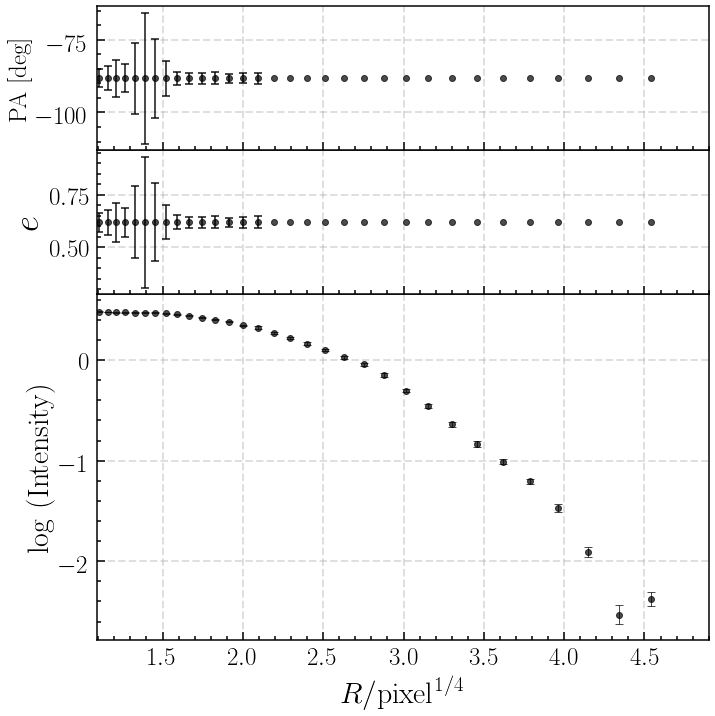

In [40]:
_ = plotting.display_intensity_shape(ell_i_3, x_max=4.9, show_avg=False)

#### Stage 4

* We need the output binary table from `ellipse` `stage=3`. For this demo, it is named `dwarf_example_i_ellip_3.bin` and this information is in the `bin_i_3` variable.

* We will run `ellipse` in `stage=4` "force-photometry" mode for the g- and r-band images to derive color profiles.

* This should be really fast too.

* Sometimes you will see warnings about `Polyfit`. This is just my old recipe to fix HSC sky issue and it is not very stable. I no longer use it and will remove it. Right now it should affect any of your result other than annoying you.

In [41]:
stage = 4

# g-band 
ell_g_4, bin_g_4 = galSBP.galSBP(g_fits, inEllip=bin_i_3, stage=stage)

# r-band 
ell_r_4, bin_r_4 = galSBP.galSBP(r_fits, inEllip=bin_i_3, stage=stage)

...Running ellipse in step 4 
> Attempts: 1


/Users/song/Dropbox/work/project/kungpao/kungpao/isophote/galSBP.py:525: RankWarning: Polyfit may be poorly conditioned
  order=polyOrder)
/Users/song/Dropbox/work/project/kungpao/kungpao/isophote/galSBP.py:525: RankWarning: Polyfit may be poorly conditioned
  order=polyOrder)


...Running ellipse in step 4 
> Attempts: 1


/Users/song/Dropbox/work/project/kungpao/kungpao/isophote/galSBP.py:525: RankWarning: Polyfit may be poorly conditioned
  order=polyOrder)
/Users/song/Dropbox/work/project/kungpao/kungpao/isophote/galSBP.py:525: RankWarning: Polyfit may be poorly conditioned
  order=polyOrder)


* The g-band image actually looks different. I guess this is due to the sensitivity to on-going SF and dust?

* The 1-D profile also shows a "bump" in the inner region and a weird result in the outskirt. I guess that's because something is not masked out properly?

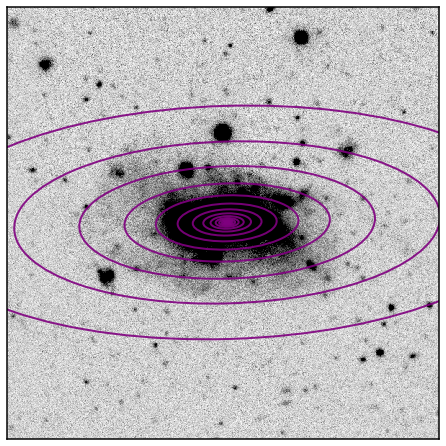

In [42]:
plotting.display_isophote(g_img, ell_g_4, zoom=2, cmap='Greys', iso_color='purple')

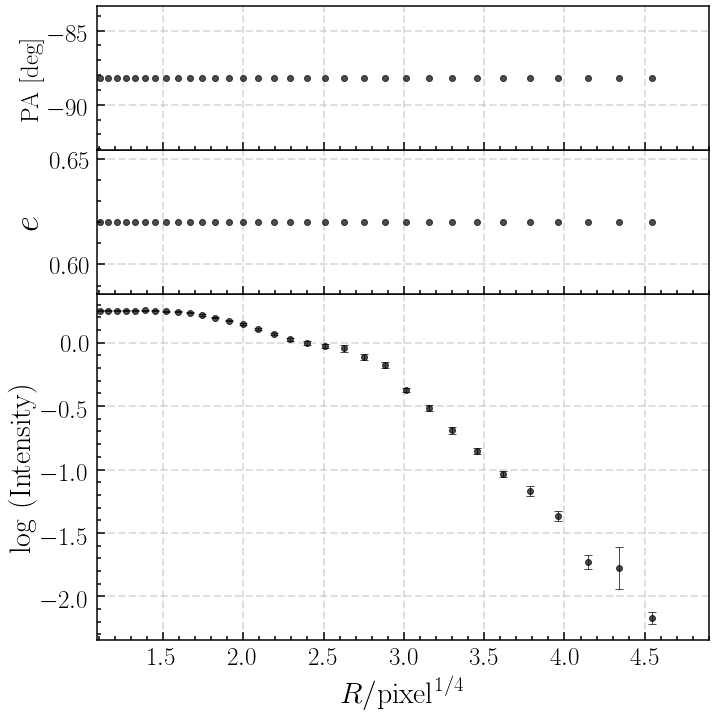

In [43]:
_ = plotting.display_intensity_shape(ell_g_4, x_max=4.9, show_avg=False)

* If you provide correct exposure time (which is 1 sec for HSC coadd), pixel size, and zeropoint, the code will convert the intensity profile into surface brightness profile and measure its error. You can find them in the `sbp` and `sbp_err` columns in the output catalog.

In [44]:
ell_i_3['sbp'] == -2.5 * np.log10(ell_i_3['intens'] / (0.168 ** 2)) + 27.0

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

* We can plot the 3-band surface brightness profiles and color profiles now.

* If `pix` (pixel scale) is provided, `sma_arcsec` is the major axis distance in arcsec unit and `rsma_arcsec` is the $R^{1/4}$ one.

* Uncertainty of color is a little more complicated, especially in the outskirt. But here we just use the combination of surface brightness errors in each band. 

* I normally first plot the color against the refernce band. In this case, it is the `g-i` and `r-i` color.

* The difference of surface brightness profile and color profile in the inner region is likely caused by seeing difference between two bands.
    - I sometime plot the 1-D PSF profiles to show that.
    - To derive reliable color profile, it is better to convolve all images into a common seeing condition. But this degrades the image quanlity in i-band for HSC.
    - A better solution is to forward model them in 2-D...but that's for another demo...

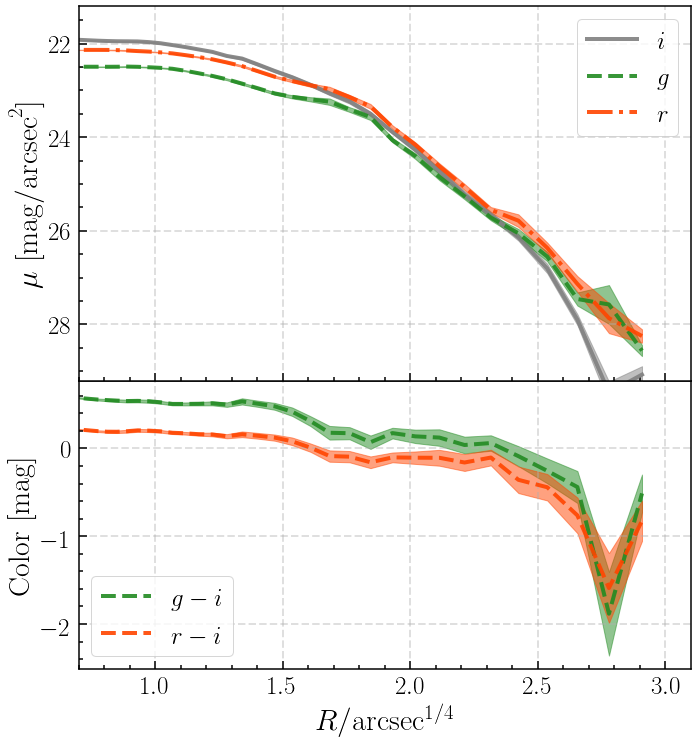

In [45]:
fig = plt.figure(figsize=(10, 10))

ax2 = fig.add_axes([0.08, 0.07, 0.85, 0.40])
ax1 = fig.add_axes([0.08, 0.47, 0.85, 0.52])

# 1-D profile
ax1.grid(linestyle='--', alpha=0.4, linewidth=2)

# i-band
ax1.fill_between(ell_i_3['rsma_asec'], 
                 ell_i_3['sbp'] - ell_i_3['sbp_err'], ell_i_3['sbp'] + ell_i_3['sbp_err'],
                 color='grey', alpha=0.5)
ax1.plot(ell_i_3['rsma_asec'], ell_i_3['sbp'], linestyle='-', linewidth=4.0, 
         alpha=0.9, color='grey', label=r'$i$')

# g-band
ax1.fill_between(ell_g_4['rsma_asec'], 
                 ell_g_4['sbp'] - ell_g_4['sbp_err'], ell_g_4['sbp'] + ell_g_4['sbp_err'],
                 color='forestgreen', alpha=0.5)
ax1.plot(ell_g_4['rsma_asec'], ell_g_4['sbp'], linestyle='--', linewidth=4.0, 
         alpha=0.9, color='forestgreen', label=r'$g$')

# r-band
ax1.fill_between(ell_r_4['rsma_asec'], 
                 ell_r_4['sbp'] - ell_r_4['sbp_err'], ell_r_4['sbp'] + ell_r_4['sbp_err'],
                 color='orangered', alpha=0.5)
ax1.plot(ell_r_4['rsma_asec'], ell_r_4['sbp'], linestyle='-.', linewidth=4.0, 
         alpha=0.9, color='orangered', label=r'$r$')

ax1.set_xlim(0.7, 3.1)
ax1.set_ylim(29.2, 21.2)
ax1.legend(loc='best', fontsize=25)
_ = ax1.set_ylabel(r'$\mu\ [{\rm mag/arcsec}^2]$', fontsize=30)
ax1.xaxis.set_major_formatter(NullFormatter())

# Color profile
ax2.grid(linestyle='--', alpha=0.4, linewidth=2)

_ = ax2.set_xlabel(r'$R/\mathrm{arcsec}^{1/4}$', fontsize=30)
_ = ax2.set_ylabel(r'$\rm Color\ [mag]$', fontsize=30)

# g-i

gi_color = ell_g_4['sbp'] - ell_i_3['sbp']
gi_err = np.sqrt(ell_g_4['sbp_err'] ** 2 + ell_i_3['sbp_err'] ** 2)
ax2.fill_between(ell_g_4['rsma_asec'], gi_color - gi_err, gi_color + gi_err,
                 color='forestgreen', alpha=0.5)
ax2.plot(ell_i_3['rsma_asec'], gi_color, linestyle='--', 
         linewidth=4.0, alpha=0.9, color='forestgreen', label=r'$g-i$')

# r-i
ri_color = ell_r_4['sbp'] - ell_i_3['sbp']
ri_err = np.sqrt(ell_r_4['sbp_err'] ** 2 + ell_i_3['sbp_err'] ** 2)
ax2.fill_between(ell_r_4['rsma_asec'], ri_color - ri_err, ri_color + ri_err,
                 color='orangered', alpha=0.5)
ax2.plot(ell_i_3['rsma_asec'], ri_color, linestyle='--', 
         linewidth=4.0, alpha=0.9, color='orangered', label=r'$r-i$')

ax2.set_xlim(0.7, 3.1)
ax2.legend(loc='best', fontsize=25)

#### What's missing from the demo:

- Generate 2-D model based on the `ellipse` output and check the "residual" image.
- Simple 1-D Sersic fit to understand the 1-D profile better.